In [182]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [183]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrBandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'

#file name
fname='F0591_FO_IMA_07018935_FORF253_CAL_0039-0061_Field_12.fits'

#Name of field
field='Field12'

#wavelength of data
wavelength=25.2

In [184]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

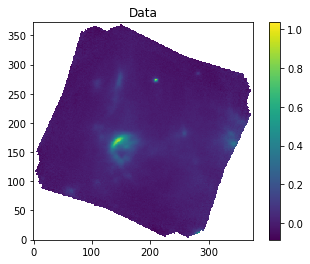

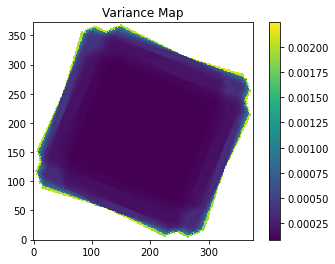

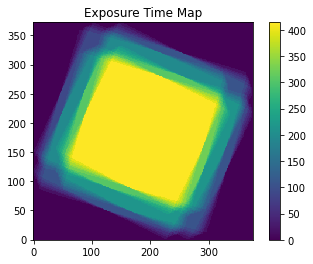

In [185]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

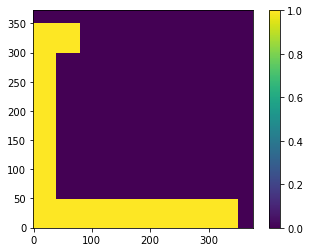

In [186]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.1,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:50,0:350]=1
mask2[0:350,0:40]=1
mask2[300:350,40:80]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [187]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

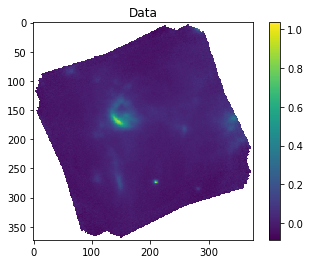

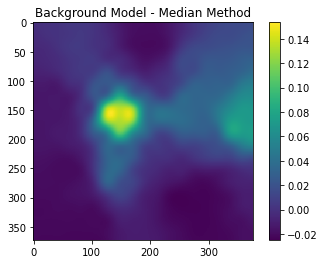

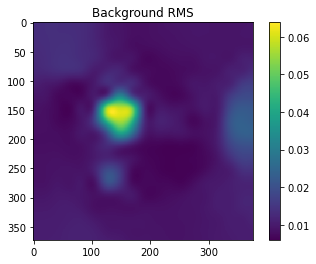

In [188]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [189]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

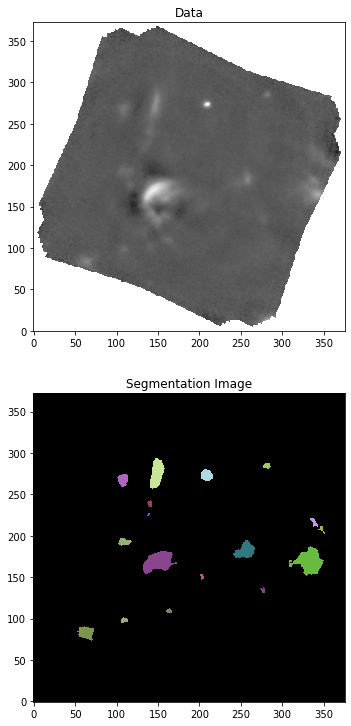

In [190]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [191]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,63.36296548273029,82.93487587329392,"266.8224882857099,-28.539273584982126",0.004783853144277256,0.0014839640906396654,0.3516994894816007,237.0,4.522105457563277,3.611741434397223,-16.46288827790931,0.05113045083976349,0.015088205998003784,0.0744302752548665,0.6017482746524067,0.20131419572346743,1.2520568096309441,9.636669685223229,23.767099968340727,nan,1.4619072403764375,17.129776782043425,nan
3,109.1313120305538,98.21315814795808,"266.81137310341296,-28.536016662111024",0.017154668583682114,0.019144489246395783,0.8615020160878103,45.0,2.073227950921499,1.7205591862269698,22.412852775340742,0.24793736650225134,-0.07412529904102183,0.3225150231154299,0.5579212754591257,0.1701061210069913,1.2049733409449865,4.486101547237361,5.446600869748597,nan,2.5939613577180225,2.104587612549027,nan
4,163.38033372416677,109.42142040843964,"266.7981993713039,-28.53362729020948",0.061545346472411964,0.02579454563653661,0.7480418234595617,29.0,1.9771861601712262,1.1743177653860601,-9.106439141807574,0.2675593164669059,0.1466942720971531,0.7133947179136714,0.8045138877464353,0.40606616157764164,1.6836892180722658,3.8291312069758323,5.80949392956788,nan,3.043469261150643,1.4884107485881486,nan
5,276.985460318439,134.3320735648956,"266.77061369321416,-28.52831250967875",0.028167789212409946,0.033259816289535435,1.064314121265134,32.0,2.0050197489529333,1.3365360949714031,-69.4271088943176,0.521397652262909,0.2046688022530305,0.28715949490068565,0.7454201067979412,0.33340502223513135,1.5001613173760437,4.012337280119095,4.179135915211229,nan,3.0181502403116154,1.012164710204879,nan
6,203.11357301754765,150.35218470071285,"266.78855089538445,-28.524895850424606",0.05865958919091457,0.036728197833914476,1.0283895393496054,28.0,2.0945233665901815,1.088524580712848,-80.61829225626086,0.8275940167674813,0.19814922609014204,0.2443139430135552,0.8543485936116572,0.4802996242123896,1.9241856396283945,3.9304739700656803,4.619340015117359,nan,3.3788770521176112,0.7974861750716667,nan
7,335.58114043464747,168.40764339687635,"266.75638784847433,-28.521040615393893",-0.009163158330844117,0.06584682958269088,51.75560805199503,786.0,7.991841386819384,7.288203452159915,-31.718434472331538,0.016532890136914138,0.0028345978748891996,0.017950070333461587,0.4102891960202175,0.08804453199233275,1.0965447711878762,18.00994314560717,nan,nan,nan,75.80115210266948,nan
8,148.39464899512188,168.6654489174557,"266.8018365267905,-28.52098821622537",0.13108665160118524,0.13318498048096425,90.69897170753666,681.0,9.008341837949713,5.085691323077189,22.6025243075513,0.016213700459469158,-0.018692134204473392,0.03477252136528444,0.8253964467698244,0.4354464545680823,1.7713111680751898,17.225189035907945,276.4971371812441,nan,1.4723812045855547,220.52053808777143,nan
10,255.70342306572218,182.2056794990988,"266.77578238503605,-28.518099993631434",0.002840882506535153,0.03205118460635824,10.92945395076816,341.0,5.866653494511201,4.070619964716111,30.591339712107573,0.037160085438830426,-0.027419757473485573,0.052245020681237944,0.720112587903321,0.3061427663105458,1.4412186707093761,11.889809161383923,27.208479835302928,nan,1.7628537718154995,18.341188292557547,nan


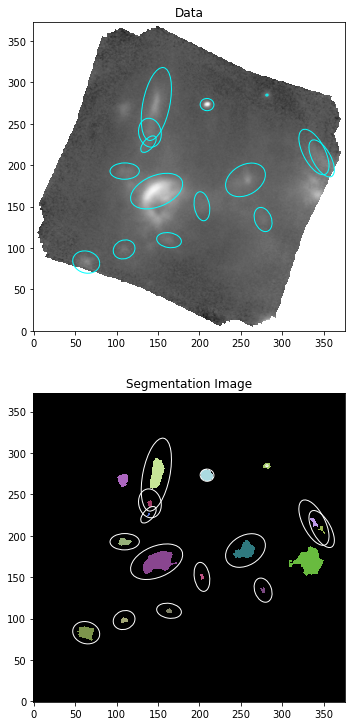

In [192]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

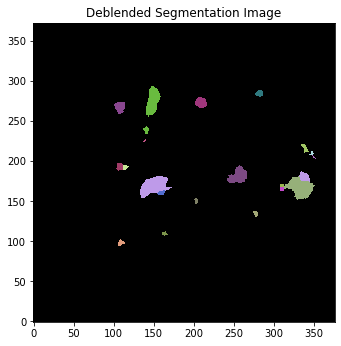

In [193]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [194]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,63.36296548273029,82.93487587329392,"266.8224882857099,-28.539273584982126",0.004783853144277256,0.0014839640906396654,0.3516994894816007,237.0,4.522105457563277,3.611741434397223,-16.46288827790931,0.05113045083976349,0.015088205998003784,0.0744302752548665,0.6017482746524067,0.20131419572346743,1.2520568096309441,9.636669685223229,23.767099968340727,nan,1.4619072403764375,17.129776782043425,nan
2,109.1313120305538,98.21315814795808,"266.81137310341296,-28.536016662111024",0.017154668583682114,0.019144489246395783,0.8615020160878103,45.0,2.073227950921499,1.7205591862269698,22.412852775340742,0.24793736650225134,-0.07412529904102183,0.3225150231154299,0.5579212754591257,0.1701061210069913,1.2049733409449865,4.486101547237361,5.446600869748597,nan,2.5939613577180225,2.104587612549027,nan
3,163.38033372416677,109.42142040843964,"266.7981993713039,-28.53362729020948",0.061545346472411964,0.02579454563653661,0.7480418234595617,29.0,1.9771861601712262,1.1743177653860601,-9.106439141807574,0.2675593164669059,0.1466942720971531,0.7133947179136714,0.8045138877464353,0.40606616157764164,1.6836892180722658,3.8291312069758323,5.80949392956788,nan,3.043469261150643,1.4884107485881486,nan
4,276.985460318439,134.3320735648956,"266.77061369321416,-28.52831250967875",0.028167789212409946,0.033259816289535435,1.064314121265134,32.0,2.0050197489529333,1.3365360949714031,-69.4271088943176,0.521397652262909,0.2046688022530305,0.28715949490068565,0.7454201067979412,0.33340502223513135,1.5001613173760437,4.012337280119095,4.179135915211229,nan,3.0181502403116154,1.012164710204879,nan
5,203.11357301754765,150.35218470071285,"266.78855089538445,-28.524895850424606",0.05865958919091457,0.036728197833914476,1.0283895393496054,28.0,2.0945233665901815,1.088524580712848,-80.61829225626086,0.8275940167674813,0.19814922609014204,0.2443139430135552,0.8543485936116572,0.4802996242123896,1.9241856396283945,3.9304739700656803,4.619340015117359,nan,3.3788770521176112,0.7974861750716667,nan
6,255.70342306572218,182.2056794990988,"266.77578238503605,-28.518099993631434",0.002840882506535153,0.03205118460635824,10.92945395076816,341.0,5.866653494511201,4.070619964716111,30.591339712107573,0.037160085438830426,-0.027419757473485573,0.052245020681237944,0.720112587903321,0.3061427663105458,1.4412186707093761,11.889809161383923,27.208479835302928,nan,1.7628537718154995,18.341188292557547,nan
7,138.5453063391116,225.37426330899123,"266.80422595079926,-28.508890054243956",0.025879389625669644,0.03275177271117208,0.36026949982289286,11.0,1.284893856776817,0.641587657333718,48.49918683345218,1.6286211183564476,-1.8100405293893358,1.4064282388909168,0.8664111618872365,0.5006687486675716,2.002678577260234,2.3913814632910357,4.451127933873627,nan,3.803603982852694,0.374503025904856,nan
8,140.30785876277193,239.16041146464852,"266.8037975836747,-28.505949062964326",0.03199654581629935,0.03702888711768976,1.55521325894297,42.0,2.088742880442195,1.6090878946547378,-78.11728520916645,0.37956779026367704,0.0632767516833228,0.23586542238555594,0.6376069102845002,0.22963811883151097,1.2980912275711185,4.390337844601962,13.168636724849547,nan,3.3705327134781444,1.966288401404015,nan


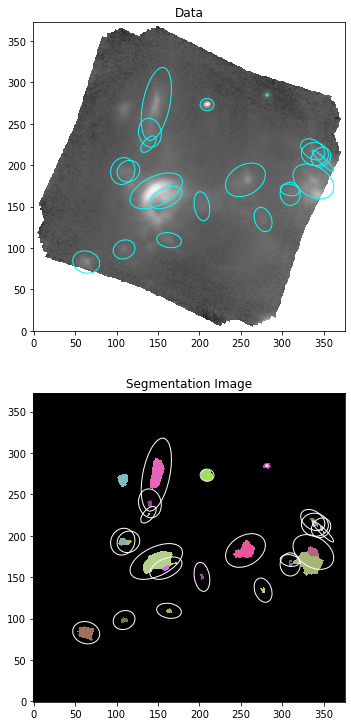

In [195]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [196]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [197]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [198]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,63.36296548273029,82.93487587329392,"266.8224882857099,-28.539273584982126",0.004783853144277256,0.0014839640906396654,0.3516994894816007,237.0,4.522105457563277,3.611741434397223,-16.46288827790931,0.05113045083976349,0.015088205998003784,0.0744302752548665,0.6017482746524067,0.20131419572346743,1.2520568096309441,9.636669685223229,23.767099968340727,0.6604452657742073,1.4619072403764375,17.129776782043425,0.36540657,0.0013996295579044448,0.0015085008484991746,0.0014781811299290366,20.14680584261134
2,109.1313120305538,98.21315814795808,"266.81137310341296,-28.536016662111024",0.017154668583682114,0.019144489246395783,0.8615020160878103,45.0,2.073227950921499,1.7205591862269698,22.412852775340742,0.24793736650225134,-0.07412529904102183,0.3225150231154299,0.5579212754591257,0.1701061210069913,1.2049733409449865,4.486101547237361,5.446600869748597,0.2678810043288472,2.5939613577180225,2.104587612549027,0.084053345,0.019547477870130062,0.019704318358452485,0.0018516946575124035,2.136061887247582
3,163.38033372416677,109.42142040843964,"266.7981993713039,-28.53362729020948",0.061545346472411964,0.02579454563653661,0.7480418234595617,29.0,1.9771861601712262,1.1743177653860601,-9.106439141807574,0.2675593164669059,0.1466942720971531,0.7133947179136714,0.8045138877464353,0.40606616157764164,1.6836892180722658,3.8291312069758323,5.80949392956788,0.1956043467463472,3.043469261150643,1.4884107485881486,0.05128833,0.025811683051015586,0.02564025288068206,0.0033042960943519867,1.6694701617549519
4,276.985460318439,134.3320735648956,"266.77061369321416,-28.52831250967875",0.028167789212409946,0.033259816289535435,1.064314121265134,32.0,2.0050197489529333,1.3365360949714031,-69.4271088943176,0.521397652262909,0.2046688022530305,0.28715949490068565,0.7454201067979412,0.33340502223513135,1.5001613173760437,4.012337280119095,4.179135915211229,0.2251638006047607,3.0181502403116154,1.012164710204879,0.057881318,0.03332092916666614,0.03328484982934021,0.00020903977783879202,0.9551289032298733
5,203.11357301754765,150.35218470071285,"266.78855089538445,-28.524895850424606",0.05865958919091457,0.036728197833914476,1.0283895393496054,28.0,2.0945233665901815,1.088524580712848,-80.61829225626086,0.8275940167674813,0.19814922609014204,0.2443139430135552,0.8543485936116572,0.4802996242123896,1.9241856396283945,3.9304739700656803,4.619340015117359,0.21387132419213606,3.3788770521176112,0.7974861750716667,0.050227914,0.036734679201281976,0.03680196749004117,0.0008748557339887254,0.7671388946105064
6,255.70342306572218,182.2056794990988,"266.77578238503605,-28.518099993631434",0.002840882506535153,0.03205118460635824,10.92945395076816,341.0,5.866653494511201,4.070619964716111,30.591339712107573,0.037160085438830426,-0.027419757473485573,0.052245020681237944,0.720112587903321,0.3061427663105458,1.4412186707093761,11.889809161383923,27.208479835302928,0.36702601998866674,1.7628537718154995,18.341188292557547,0.1773592,0.029579719686117542,0.030203254807525167,0.004922388378476867,5.666512565751167
7,138.5453063391116,225.37426330899123,"266.80422595079926,-28.508890054243956",0.025879389625669644,0.03275177271117208,0.36026949982289286,11.0,1.284893856776817,0.641587657333718,48.49918683345218,1.6286211183564476,-1.8100405293893358,1.4064282388909168,0.8664111618872365,0.5006687486675716,2.002678577260234,2.3913814632910357,4.451127933873627,0.14648075382474912

In [199]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [200]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,63.36296548265372,82.9348758733002,"266.8224882857099,-28.539273584982126",2.5606024964768186,0.10162943730615429,8.37862446231001,0.2056434355621641,14.62751098807972,0.331458757929932,nan,nan,nan,nan
2,109.13131203055488,98.21315814785005,"266.81137310341296,-28.536016662111024",1.0770485545613153,0.0585776497163183,3.081605864962384,0.11518508330337801,4.582549352521263,0.17171548713498264,5.310651381546856,0.22828335320138604,5.42548303233276,0.2845060240536749
3,163.38033372419636,109.42142040843034,"266.7981993713039,-28.53362729020948",1.0832583103480622,0.04396569503239193,3.25978093959956,0.08791093502164224,4.8785121026283536,0.1318337185876688,5.836352068884248,0.17572103886544785,6.061101583217357,0.21958928971165093
4,276.9854603182945,134.3320735649112,"266.77061369321416,-28.52831250967875",0.6739373775176101,0.047138780347941896,2.1777573112413613,0.09465747331416269,3.304143741188565,0.14222697747487606,3.834326138782886,0.18986567964681453,3.8354374608271486,0.23742763299844227
5,203.11357301748336,150.352184700716,"266.78855089538445,-28.524895850424606",0.5765134109529283,0.04381488348711807,1.930832956155988,0.08753442572244442,3.5410977490737547,0.13110812221505685,4.764682050361306,0.17465921282803398,5.0736390129030555,0.2182394954086627
6,255.70342306567733,182.20567949917285,"266.77578238503605,-28.518099993631434",2.073125839412577,0.044329165398484624,7.082307285271413,0.08866077680535545,12.708641902735893,0.13300968839197308,17.53798662791766,0.17737218471832944,21.30684379585312,0.2217607135938712
7,138.5453063389932,225.37426330900703,"266.80422595079926,-28.508890054243956",0.6522476697631812,0.04414996404375439,2.0584701262451865,0.08832451636050494,3.4649698992281808,0.13253052573936744,4.878586310818636,0.17679360847228956,6.1163708071437455,0.22107869193282023
8,140.3078587627342,239.16041146468723,"266.8037975836747,-28.505949062964326",1.058413771971385,0.04432617799825424,3.4630194607351634,0.08867737775599772,5.981877851144345,0.13312686637358498,8.067700847872214,0.17758177865734218,9.895867291118401,0.22200434730718704


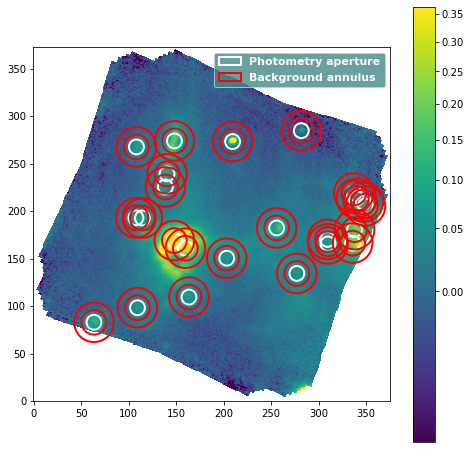

In [201]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [202]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [203]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-203-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,63.36296548265372,82.9348758733002,"266.8224882857099,-28.539273584982126",14.62751098807972,0.331458757929932,0.00032023949502546544,0.0012461211195753251,14.566105835031312,0.331458757929932,0.00032023949502546544,20.947590630820212
2,109.13131203055488,98.21315814785005,"266.81137310341296,-28.536016662111024",4.582549352521263,0.17171548713498264,-0.0006635403480784591,-0.0016707769560551956,4.709781618561129,0.17171548713498264,0.0,10.244899963776815
3,163.38033372419636,109.42142040843034,"266.7981993713039,-28.53362729020948",4.8785121026283536,0.1318337185876688,-6.157756997808834e-05,-0.0004989578897924748,4.890319453587837,0.1318337185876688,0.0,12.140474566080783
4,276.9854603182945,134.3320735649112,"266.77061369321416,-28.52831250967875",3.304143741188565,0.14222697747487606,-0.0006125629706092359,-0.0014892440485094886,3.421601217690822,0.14222697747487606,0.0,8.178056115821917
5,203.11357301748336,150.352184700716,"266.78855089538445,-28.524895850424606",3.5410977490737547,0.13110812221505685,-0.000961636388215222,-0.0015106549564000218,3.7254892139384466,0.13110812221505685,0.0,9.274279850347158
6,255.70342306567733,182.20567949917285,"266.77578238503605,-28.518099993631434",12.708641902735893,0.13300968839197308,0.003929320084116107,0.005340458860726083,11.955204225967917,0.13300968839197308,0.003929320084116107,11.445696018606453
7,138.5453063389932,225.37426330900703,"266.80422595079926,-28.508890054243956",3.4649698992281808,0.13253052573936744,-0.0028291217595862346,-0.003059233405764118,4.007447193061542,0.13253052573936744,0.0,9.922509713125278
8,140.3078587627342,239.16041146468723,"266.8037975836747,-28.505949062964326",5.981877851144345,0.13312686637358498,0.0004693294974441941,0.0032158628713175328,5.891885048668804,0.13312686637358498,0.0004693294974441941,11.243383431585972


In [204]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [205]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64
1,63.36296548273029,82.93487587329392,"266.8224882857099,-28.539273584982126",0.004783853144277256,0.0014839640906396654,0.3516994894816007,237.0,4.522105457563277,3.611741434397223,-16.46288827790931,0.05113045083976349,0.015088205998003784,0.0744302752548665,0.6017482746524067,0.20131419572346743,1.2520568096309441,9.636669685223229,23.767099968340727,0.6604452657742073,1.4619072403764375,17.129776782043425,0.36540657,0.0013996295579044448,0.0015085008484991746,0.0014781811299290366,20.14680584261134,2.5606024964768186,0.10162943730615429,8.37862446231001,0.2056434355621641,14.62751098807972,0.331458757929932,nan,nan,nan,nan,0.00032023949502546544,0.0012461211195753251,14.566105835031312,0.331458757929932,0.00032023949502546544,20.947590630820212,2.553779701693662,8.351333283177382,nan,nan,7.657138299459337,16.47922851836017,nan,nan,20.947590630820212,C7Field12,25.2
2,109.1313120305538,98.21315814795808,"266.81137310341296,-28.536016662111024",0.017154668583682114,0.019144489246395783,0.8615020160878103,45.0,2.073227950921499,1.7205591862269698,22.412852775340742,0.24793736650225134,-0.07412529904102183,0.3225150231154299,0.5579212754591257,0.1701061210069913,1.2049733409449865,4.486101547237361,5.446600869748597,0.2678810043288472,2.5939613577180225,2.104587612549027,0.084053345,0.019547477870130062,0.019704318358452485,0.0018516946575124035,2.136061887247582,1.0770485545613153,0.0585776497163183,3.081605864962384,0.11518508330337801,4.582549352521263,0.17171548713498264,5.310651381546856,0.22828335320138604,5.42548303233276,0.2845060240536749,-0.0006635403480784591,-0.0016707769560551956,4.709781618561129,0.17171548713498264,0.0,10.244899963776815,1.0911854730101893,3.13815353875788,5.536842076728839,5.778905993554609,4.451792485590569,8.805907995531943,9.75834063095971,8.45750402358261,10.244899963776815,C7Field12,25.2
3,163.38033372416677,109.42142040843964,"266.7981993713039,-28.53362729020948",0.061545346472411964,0.02579454563653661,0.7480418234595617,29.0,1.9771861601712262,1.1743177653860601,-9.106439141807574,0.2675593164669059,0.1466942720971531,0.7133947179136714,0.8045138877464353,0.40606616157764164,1.6836892180722658,3.8291312069758323,5.80949392956788,0.1956043467463472,3.043469261150643,1.4884107485881486,0.05128833,0.025811683051015586,0.02564025288068206,0.0033042960943519867,1.6694701617549519,1.0832583103480622,0.04396569503239193,3.25978093959956,0.08791093502164224,4.8785121026283536,0.1318337185876688,5.836352068884248,0.17572103886544785,6.061101583217357,0.21958928971165093,-6.157756997808834e-05,-0.0004989578897924748,4.890319453587837,0.1318337185876688,0.0,12.140474566080783,1.0845702382324494,3.2650286511371083,5.857342915034443,6.0938

In [206]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [207]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64
1,63.36296548273029,82.93487587329392,"266.8224882857099,-28.539273584982126",0.004783853144277256,0.0014839640906396654,0.3516994894816007,237.0,4.522105457563277,3.611741434397223,-16.46288827790931,0.05113045083976349,0.015088205998003784,0.0744302752548665,0.6017482746524067,0.20131419572346743,1.2520568096309441,9.636669685223229,23.767099968340727,0.6604452657742073,1.4619072403764375,17.129776782043425,0.36540657,0.0013996295579044448,0.0015085008484991746,0.0014781811299290366,20.14680584261134,2.5606024964768186,0.10162943730615429,8.37862446231001,0.2056434355621641,14.62751098807972,0.331458757929932,nan,nan,nan,nan,0.00032023949502546544,0.0012461211195753251,14.566105835031312,0.331458757929932,0.00032023949502546544,20.947590630820212,2.553779701693662,8.351333283177382,nan,nan,7.657138299459337,16.47922851836017,nan,nan,20.947590630820212,C7Field12,25.2
2,109.1313120305538,98.21315814795808,"266.81137310341296,-28.536016662111024",0.017154668583682114,0.019144489246395783,0.8615020160878103,45.0,2.073227950921499,1.7205591862269698,22.412852775340742,0.24793736650225134,-0.07412529904102183,0.3225150231154299,0.5579212754591257,0.1701061210069913,1.2049733409449865,4.486101547237361,5.446600869748597,0.2678810043288472,2.5939613577180225,2.104587612549027,0.084053345,0.019547477870130062,0.019704318358452485,0.0018516946575124035,2.136061887247582,1.0770485545613153,0.0585776497163183,3.081605864962384,0.11518508330337801,4.582549352521263,0.17171548713498264,5.310651381546856,0.22828335320138604,5.42548303233276,0.2845060240536749,-0.0006635403480784591,-0.0016707769560551956,4.709781618561129,0.17171548713498264,0.0,10.244899963776815,1.0911854730101893,3.13815353875788,5.536842076728839,5.778905993554609,4.451792485590569,8.805907995531943,9.75834063095971,8.45750402358261,10.244899963776815,C7Field12,25.2
3,163.38033372416677,109.42142040843964,"266.7981993713039,-28.53362729020948",0.061545346472411964,0.02579454563653661,0.7480418234595617,29.0,1.9771861601712262,1.1743177653860601,-9.106439141807574,0.2675593164669059,0.1466942720971531,0.7133947179136714,0.8045138877464353,0.40606616157764164,1.6836892180722658,3.8291312069758323,5.80949392956788,0.1956043467463472,3.043469261150643,1.4884107485881486,0.05128833,0.025811683051015586,0.02564025288068206,0.0033042960943519867,1.6694701617549519,1.0832583103480622,0.04396569503239193,3.25978093959956,0.08791093502164224,4.8785121026283536,0.1318337185876688,5.836352068884248,0.17572103886544785,6.061101583217357,0.21958928971165093,-6.157756997808834e-05,-0.0004989578897924748,4.890319453587837,0.1318337185876688,0.0,12.140474566080783,1.0845702382324494,3.2650286511371083,5.857342915034443,6.0938

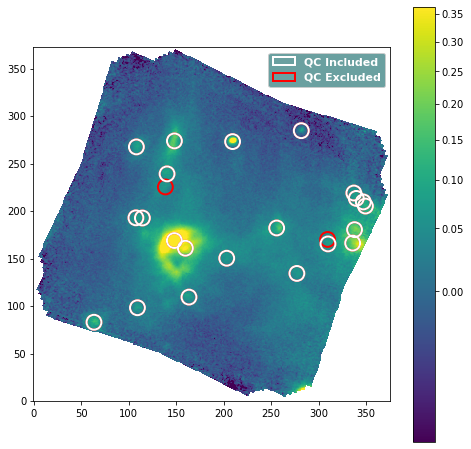

In [208]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

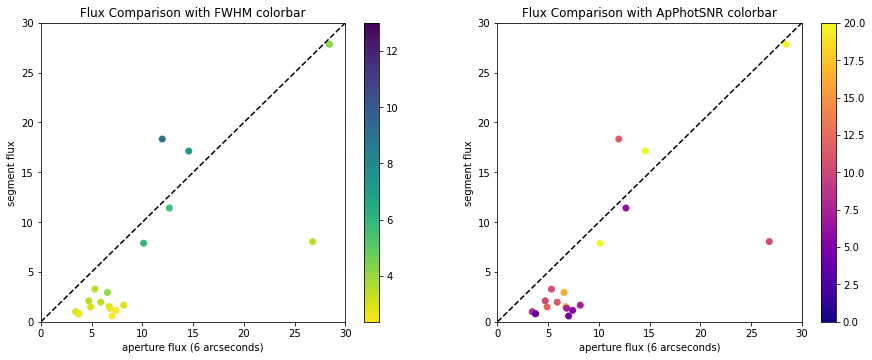

In [209]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

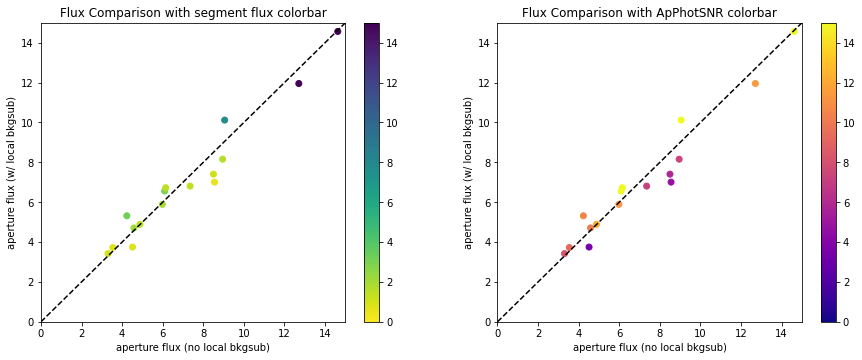

In [210]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [211]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)